In [ ]:
# basic stuff 
from scipy import stats, signal, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from google.colab import files
import os
import sklearn
import time
import json
import math
import statsmodels.api as sm
from sklearn.metrics import r2_score

# torch stuff
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch import nn
import torch.nn.functional as F

# Data

In [ ]:
# mat_20220405 = io.loadmat('20220405_Pop_FR_002_unsorted_binned_smoothed.mat')
mat_20220309 = io.loadmat('new_labels_proc.mat')

# input_20220405 = mat_20220405['data'][0][0][-3]
# output_20220405 = mat_20220405['data'][0][0][-1]
input_20220309 = mat_20220309['data'][0][0][-4]
output_20220309 = mat_20220309['data'][0][0][-1]

In [ ]:
# input_20220405.shape, output_20220405.shape

In [ ]:
input_20220309.shape, output_20220309.shape

((17969, 24), (17969, 96))

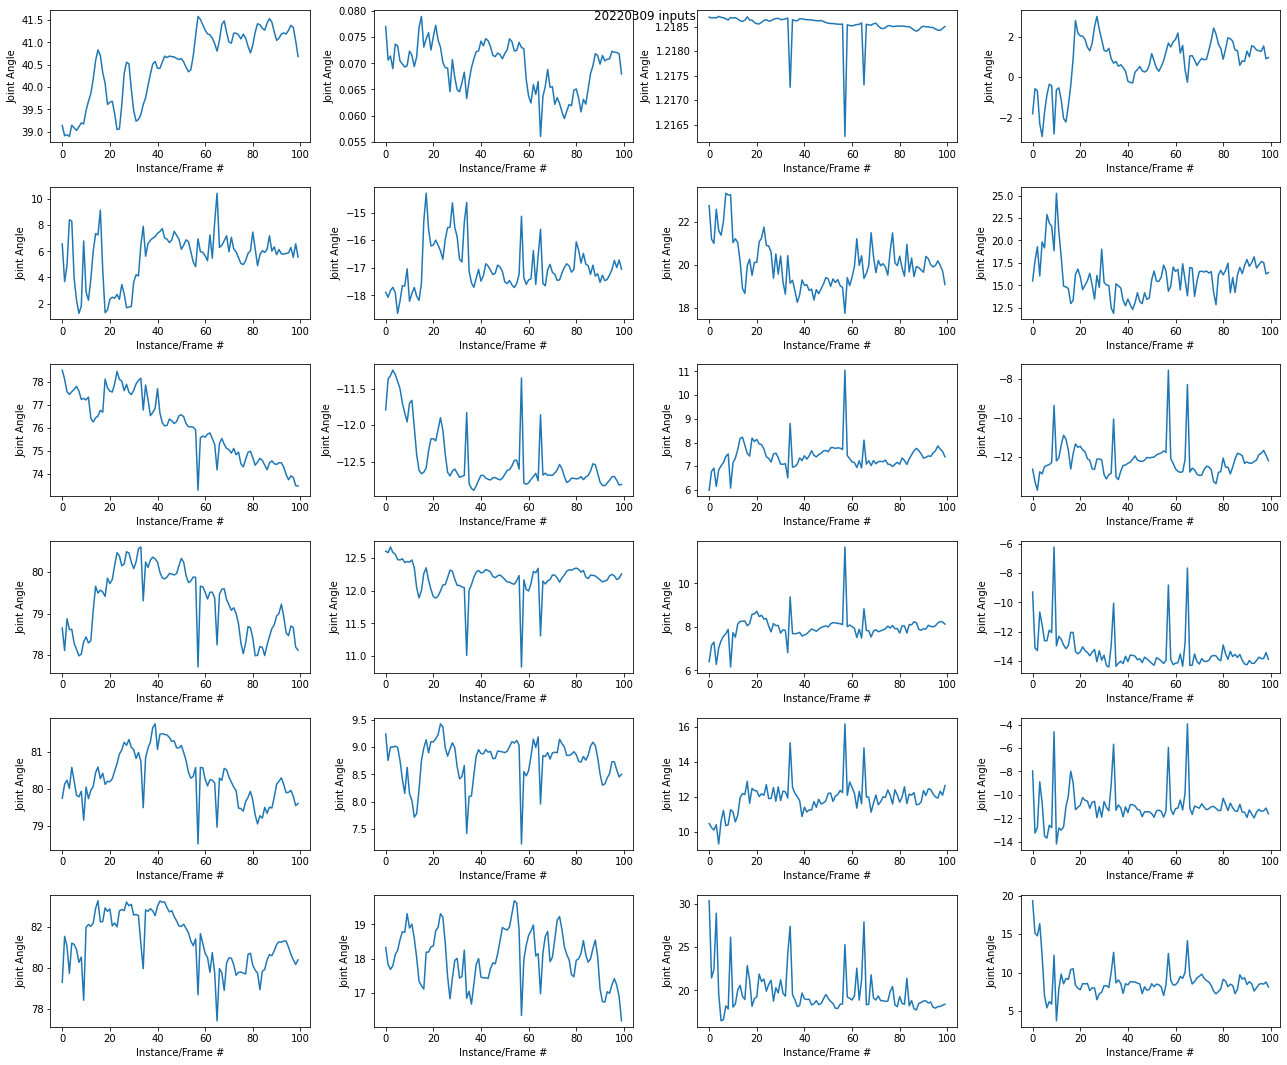

In [ ]:
f, ax = plt.subplots(nrows = 6, ncols = 4)
f.set_size_inches(18, 15)
for k in range(24):
    i = k-(int(k/4)*4)
    j = int(k/4)
    ax[j][i].plot(input_20220309[:100,k])
    ax[j][i].set_xlabel('Instance/Frame #')
    ax[j][i].set_ylabel('Joint Angle')
plt.suptitle('20220309 inputs')
plt.tight_layout()
plt.show()

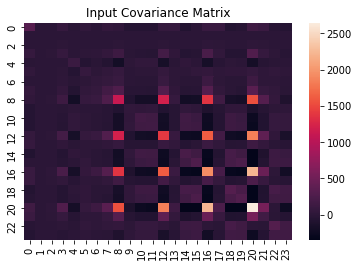

In [ ]:
import seaborn as sn
cov_matrix = np.cov(input_20220309.T)
sn.heatmap(cov_matrix)
plt.title('Input Covariance Matrix')
plt.show()

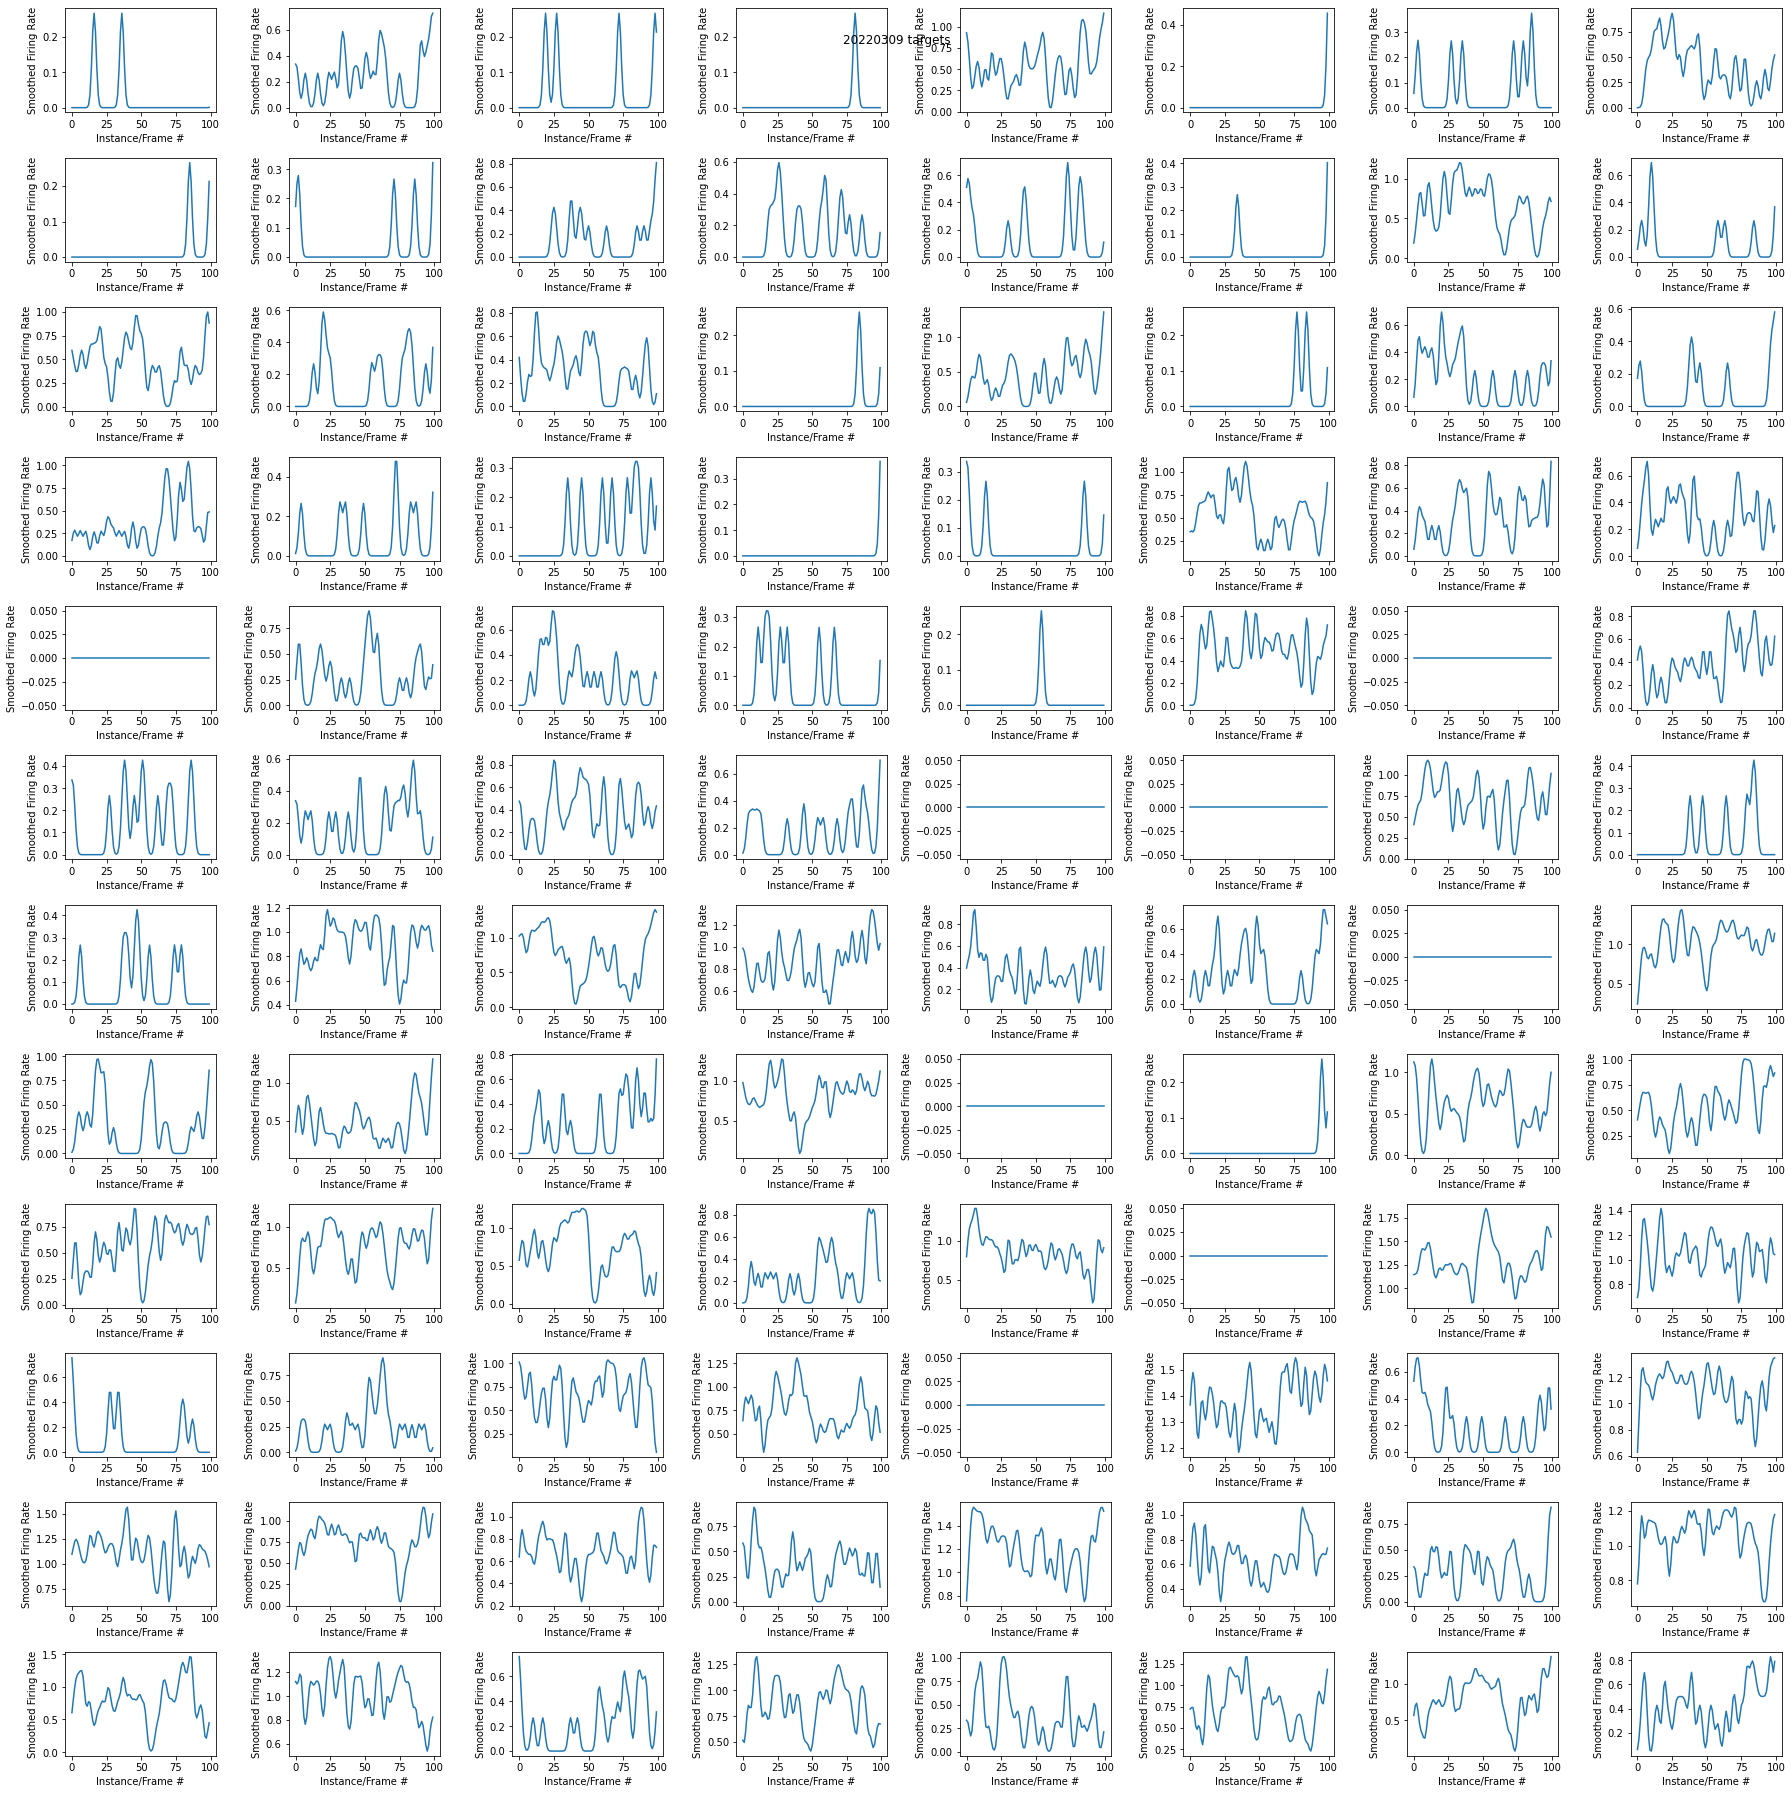

In [ ]:
nrows,ncols=12,8
f, ax = plt.subplots(nrows, ncols)
f.subplots_adjust(top=0.97)
f.set_size_inches(25, 25)
for k in range(nrows*ncols):
    i = k-(int(k/ncols)*ncols)
    j = int(k/ncols)
    ax[j][i].plot(output_20220309[:100,k])
    ax[j][i].set_xlabel('Instance/Frame #')
    ax[j][i].set_ylabel('Smoothed Firing Rate')
    # if k==nrows*ncols-1:
    #     ax[j][i].plot(np.arange(100))
    # else:
    #     ax[j][i].plot(output_20220405[:100,k])
plt.suptitle('20220309 targets')
plt.tight_layout()
plt.show()

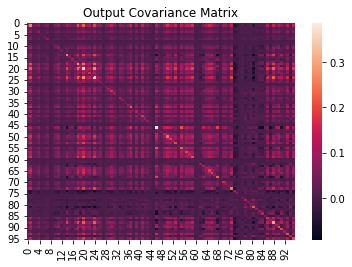

In [ ]:
import seaborn as sn
cov_matrix = np.cov(output_20220309.T)
sn.heatmap(cov_matrix)
plt.title('Output Covariance Matrix')
plt.show()

# Sklearn Linear Regression

In [ ]:
# LinearRegression() works by using the Moore-Penrose pseudoinverse of X
from sklearn.linear_model import LinearRegression 
lin_reg = LinearRegression()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_20220309, output_20220309, test_size=0.2, shuffle = False, random_state=42)

lin_reg.fit(X_train, y_train)
pred_train = lin_reg.predict(X_train)
pred_test = lin_reg.predict(X_test)

In [ ]:
lin_reg.coef_.shape

(96, 24)

In [ ]:
train_r2 = r2_score(y_train,pred_train)
test_r2 = r2_score(y_test,pred_test)
print('Train r^2: {}, Test r^2: {}'.format(train_r2, test_r2))

Train r^2: 0.14884956271521183, Test r^2: 0.06382911319806474


In [ ]:
pred_train.shape, y_train.shape

((14375, 96), (14375, 96))

# Sklearn SGD Regressor

In [ ]:
y_train.shape

(14375, 96)

In [ ]:
from sklearn.linear_model import SGDRegressor
sgd_preds_train = []
sgd_preds_test = []

for i in range(y_train.shape[1]):
    sgd_reg = SGDRegressor(max_iter=1000, eta0 = 0.01, tol=1e-6, penalty=None)
    sgd_reg.fit(X_train, y_train[:,i])
    preds_train = sgd_reg.predict(X_train)
    preds_test = sgd_reg.predict(X_test)
    sgd_preds_train.append(preds_train)
    sgd_preds_test.append(preds_test)

In [ ]:
np.stack(sgd_preds_train).T.shape, y_train.shape

((14375, 96), (14375, 96))

In [ ]:
train_r2 = r2_score(y_train,np.stack(sgd_preds_train).T)
test_r2 = r2_score(y_test,np.stack(sgd_preds_test).T)
print('Train r^2: {}, Test r^2: {}'.format(train_r2, test_r2))

Train r^2: -2.9008744110284253e+26, Test r^2: -5.498655460561163e+26


In [ ]:
sgd_preds_train = []
sgd_preds_test = []

for i in range(y_train.shape[1]):
    sgd_reg = SGDRegressor(max_iter=1000, eta0 = 0.00005, learning_rate = 'constant', tol=1e-6, penalty=None)
    sgd_reg.fit(X_train, y_train[:,i])
    preds_train = sgd_reg.predict(X_train)
    preds_test = sgd_reg.predict(X_test)
    sgd_preds_train.append(preds_train)
    sgd_preds_test.append(preds_test)

In [ ]:
train_r2 = r2_score(y_train,np.stack(sgd_preds_train).T)
test_r2 = r2_score(y_test,np.stack(sgd_preds_test).T)
print('Train r^2: {}, Test r^2: {}'.format(train_r2, test_r2))

Train r^2: -1.5825947667638856, Test r^2: -2.2647737976139983


# Building Dataloader

In [ ]:
class OSIMDataset(Dataset):
    def __init__(self, input, neuraldata, shuffle = False):
        # self.date = date
        self.inputs = input
        self.input_dim = self.inputs.shape[-1]
        self.num_neural_units = neuraldata.shape[-1]
        self.neuraloutputs = neuraldata
        self.sample_nums = np.arange(len(self.inputs))

        def shuffle_data(inputs, targets, samp_nums):
            assert len(inputs) == len(targets)
            p = np.random.permutation(len(inputs))
            return(inputs[p], targets[p], samp_nums[p])

        if shuffle == True:
            self.inputs, self.neuraloutputs, self.sample_nums = \
              shuffle_data(self.inputs, self.neuraloutputs, self.sample_nums)

    def __len__(self):
        assert len(self.inputs) == len(self.neuraloutputs)
        return len(self.inputs)

    def __getitem__(self, idx):
        input = torch.from_numpy(self.inputs[idx])
        neuraloutput = torch.from_numpy(self.neuraloutputs[idx])
        sample_num = self.sample_nums[idx]
        return input.float(), neuraloutput.float(), sample_num

In [ ]:
def get_loaders(dataset):
    num_instances = len(dataset)
    train_split = int(num_instances*.8)

    osim_train_dataset = Subset(dataset, np.arange(num_instances)[:train_split])
    osim_test_dataset = Subset(dataset, np.arange(num_instances)[train_split:])
    osim_toy_dataset = Subset(dataset, np.arange(num_instances)[:4])

    osim_train_loader = torch.utils.data.DataLoader(osim_train_dataset, batch_size=4, pin_memory=True, sampler=None)
    osim_test_loader = torch.utils.data.DataLoader(osim_test_dataset, batch_size=4, pin_memory=True)
    osim_toy_loader = torch.utils.data.DataLoader(osim_toy_dataset, batch_size=4, pin_memory=True)

    return(osim_train_loader, osim_test_loader, osim_toy_loader)

In [ ]:
# osim_dataset_20220405 = OSIMDataset(input_20220405, output_20220405[:,:24], shuffle = False)
# osim_dataset_20220405 = OSIMDataset(input_20220405, output_20220405, shuffle = False)
osim_dataset_20220309 = OSIMDataset(input_20220309, output_20220309, shuffle = False)

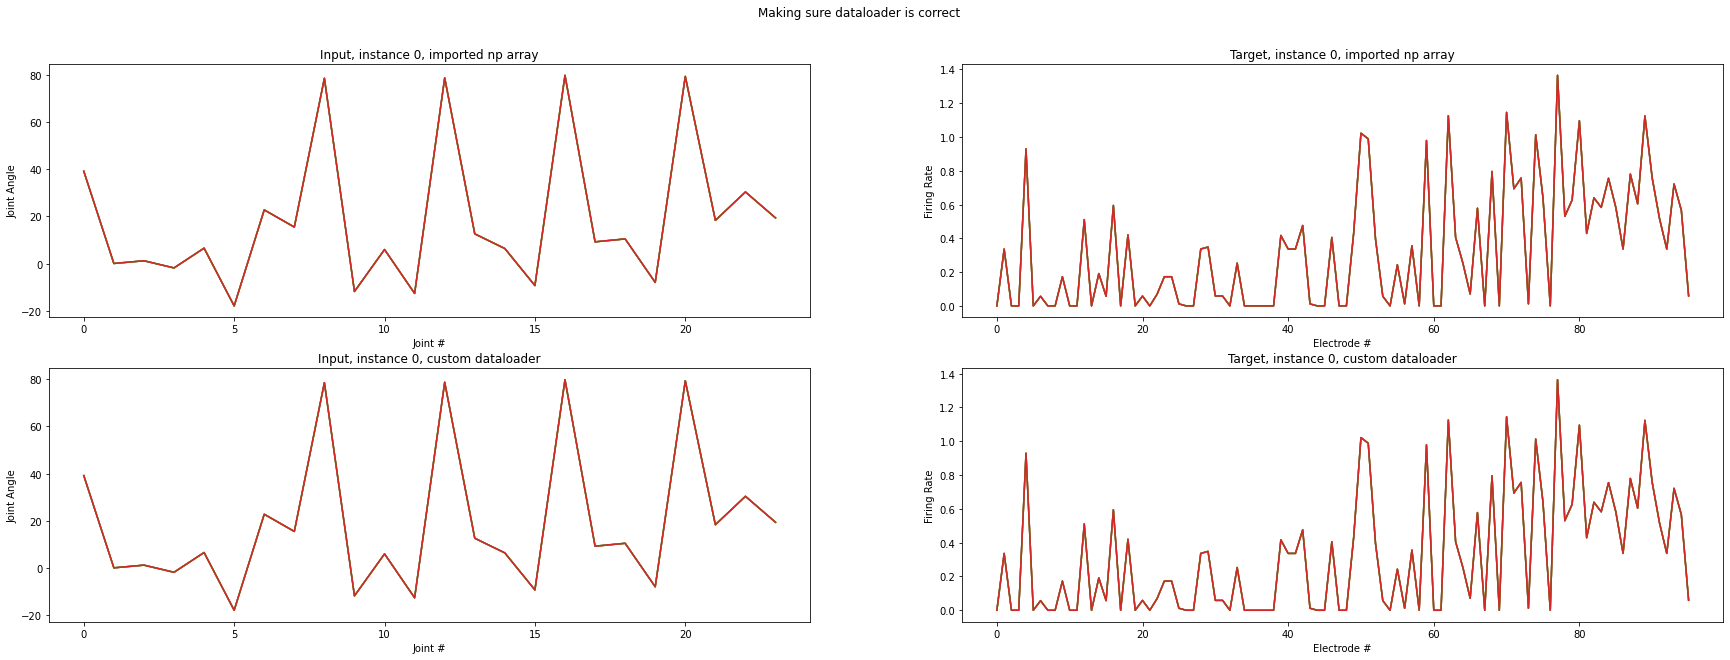

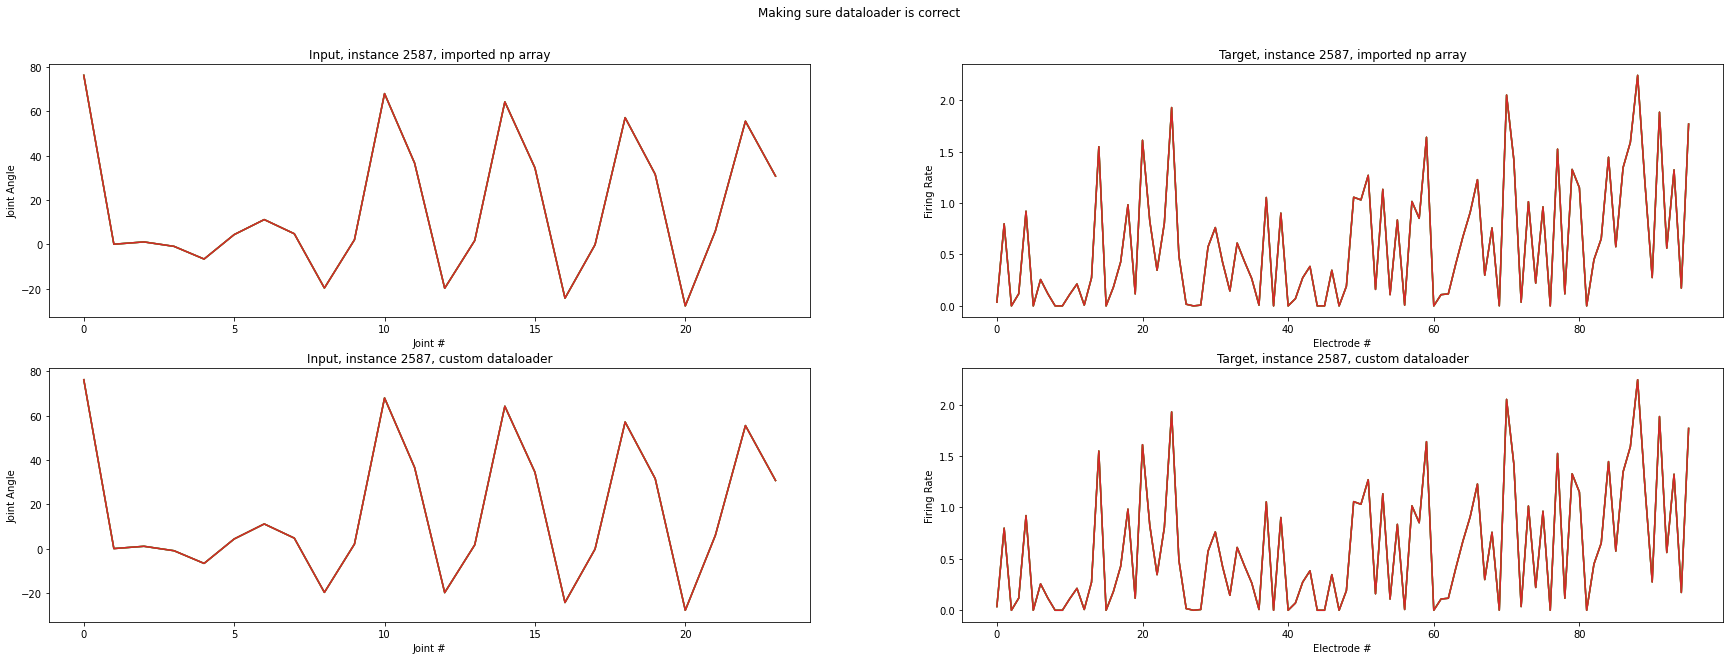

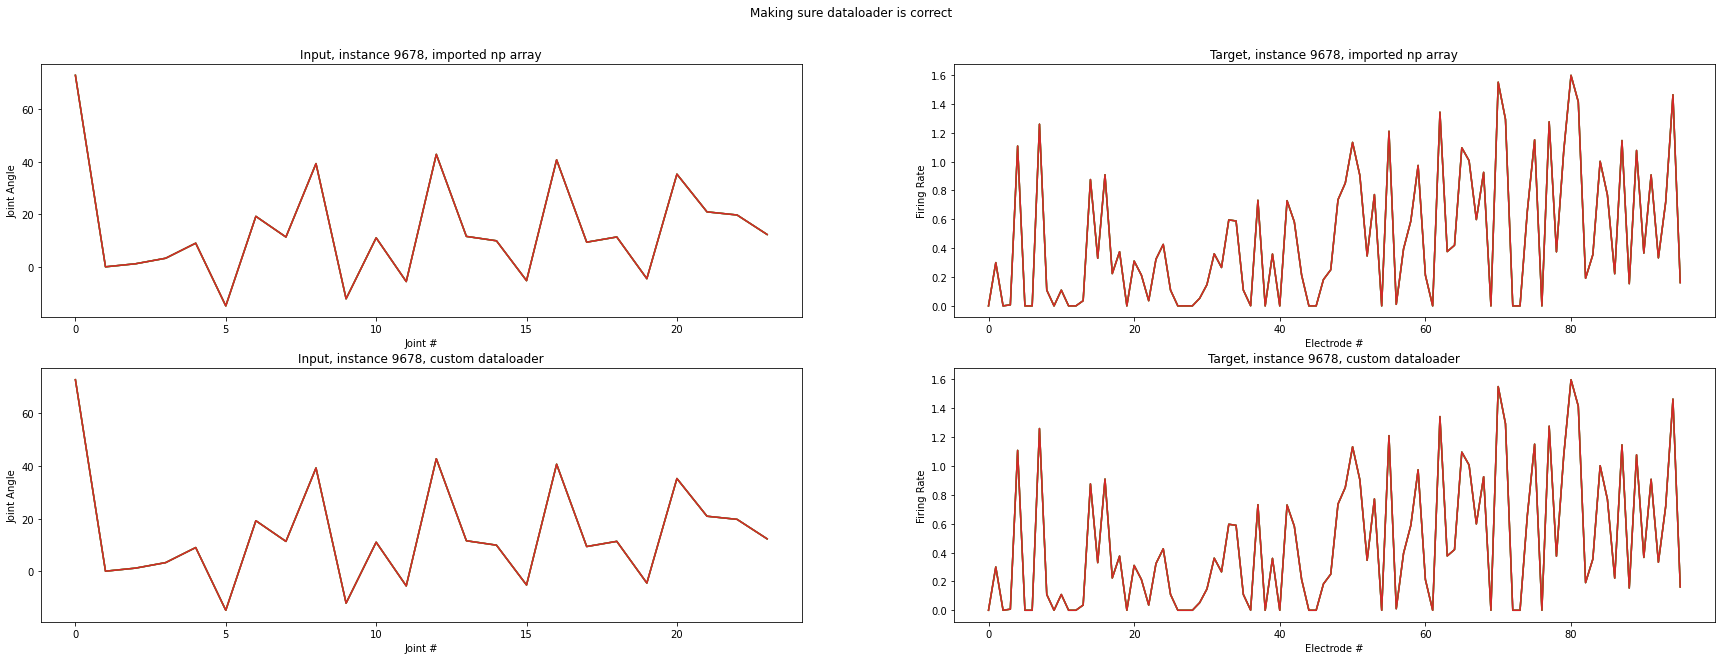

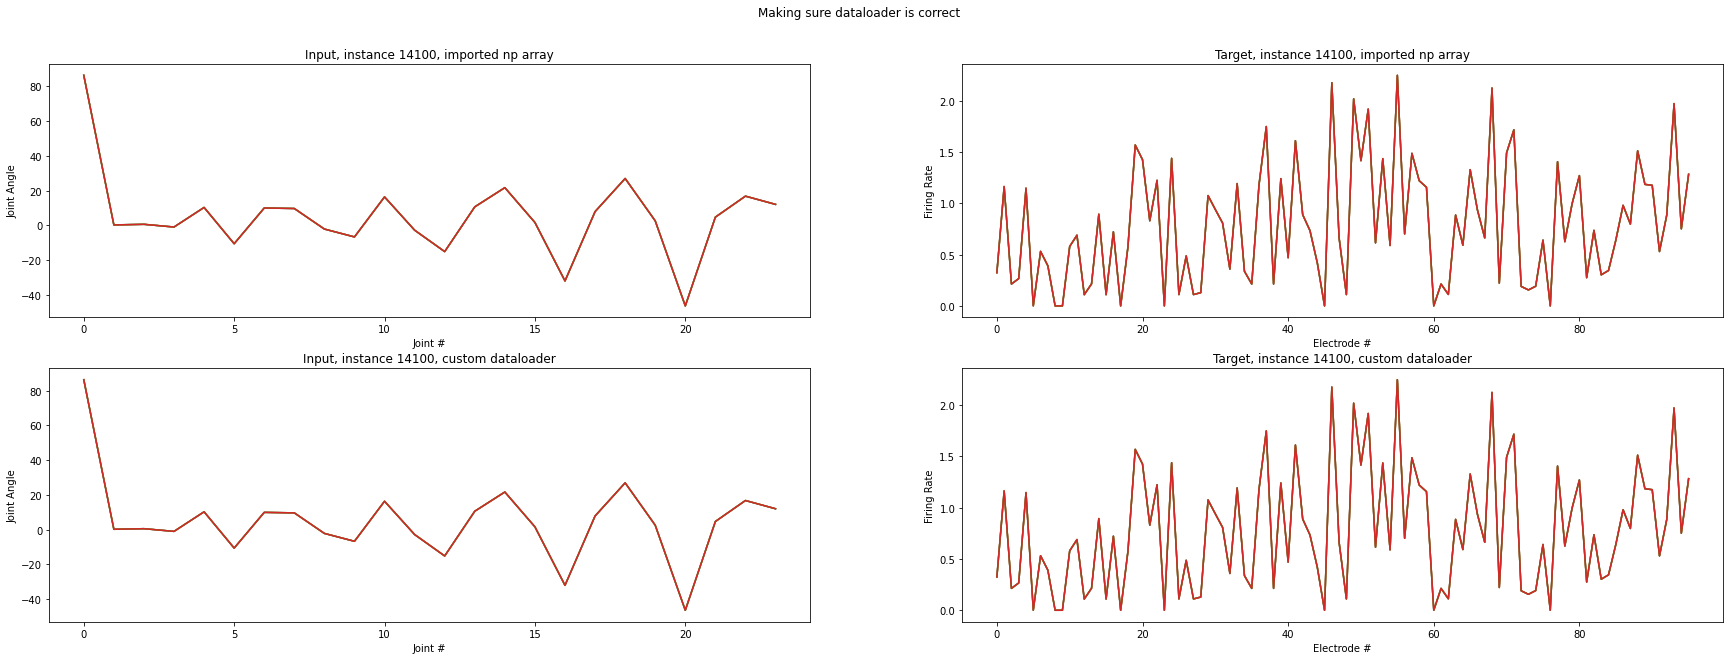

In [ ]:
instance_nums = [0,2587,9678,14100]
for instance_num in instance_nums:
    nrows,ncols=2,2
    f, ax = plt.subplots(nrows, ncols)
    f.subplots_adjust(top=0.9)
    f.set_size_inches(30, 10)
    # print('Row 1: input/output_20220405, Row 2: osim_dataset_20220405')
    f.suptitle('Making sure dataloader is correct')
    for k in range(nrows*ncols):
        ax[0][0].plot(input_20220309[instance_num])
        ax[0][0].set_title('Input, instance {}, imported np array'.format(instance_num))
        ax[0][0].set_xlabel('Joint #')
        ax[0][0].set_ylabel('Joint Angle')
        ax[0][1].plot(output_20220309[instance_num])
        ax[0][1].set_xlabel('Electrode #')
        ax[0][1].set_ylabel('Firing Rate')
        ax[0][1].set_title('Target, instance {}, imported np array'.format(instance_num))
        ax[1][0].plot(osim_dataset_20220309[instance_num][0])
        ax[1][0].set_title('Input, instance {}, custom dataloader'.format(instance_num))
        ax[1][0].set_xlabel('Joint #')
        ax[1][0].set_ylabel('Joint Angle')
        ax[1][1].plot(osim_dataset_20220309[instance_num][1])
        ax[1][1].set_xlabel('Electrode #')
        ax[1][1].set_ylabel('Firing Rate')
        ax[1][1].set_title('Target, instance {}, custom dataloader'.format(instance_num))
    # plt.tight_layout()
    plt.show()

# Model and Training

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(input_size, output_size)
        self.num_layers = 1
        self.name = 'Linear Model'

    def forward(self, x):
        x = self.fc1(x)
        return x

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train(loader, model, optimizer, criterion):
    model.train()
    batch_losses = []

    for i, (input, target, sample_num) in enumerate(loader):
        optimizer.zero_grad() #clear gradient
        input = input.to(device, dtype=torch.float)
        target = target.to(device, dtype=torch.float)
        
        pred = model(input)
        # print(pred.shape, target.shape)
        loss = criterion(pred, target)  # calculate loss
        mean_batch_loss = loss.item()
        batch_losses.append(mean_batch_loss)

        loss.backward()  # one backward pass
        optimizer.step()  # update the parameters

    avg_loss_epoch = sum(batch_losses)/len(batch_losses)
    return(avg_loss_epoch)

def test(loader, model, optimizer, criterion, scheduler):
    model.eval()
    batch_losses = []

    with torch.no_grad():
        for i, (input, target, sample_num) in enumerate(loader):
            input = input.to(device, dtype=torch.float)
            target = target.to(device, dtype=torch.float)
            pred = model(input)

            loss = criterion(pred, target)  
            mean_batch_loss = loss.item()
            batch_losses.append(mean_batch_loss)
            scheduler.step(mean_batch_loss)

    avg_loss_epoch = sum(batch_losses)/len(batch_losses)
    return(avg_loss_epoch)
    
def predict(loader, model):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for i, (input, target, sample_num) in enumerate(loader):
            input = input.to(device, dtype=torch.float)
            target = target.to(device, dtype=torch.float)
            pred = model(input)
            predictions.append(pred.cpu().data.numpy())
            targets.append(target.cpu().data.numpy())
    return(np.vstack(predictions), np.vstack(targets))

def get_pr2_osim2(real_data, predictions, lam = 0, EPS = 0.000001):
    predictions[predictions==0]=EPS
    m = np.mean(real_data, axis = 0) #average for each neuron across all instances
    m[m==0]=EPS

    d1 = real_data/predictions #element-wise division
    d2 = real_data/m
    d1[d1==0]=EPS
    d2[d2==0]=EPS

    a1=(real_data*np.log(d1))-(real_data-predictions)
    a2=(real_data*np.log(d2))-(real_data-m)
    sum1 = np.sum(a1, axis = 0) #sum across instances
    sum2 = np.sum(a2, axis = 0) #sum across instances

    sum2[sum2==0]=EPS
    pR2 = 1 - (sum1/sum2)
    return(pR2)
    
def get_pr2_osim(real_data, predictions, lam = 0, EPS = 0.000001):
    print(real_data.shape, predictions.shape)
    pr2_list = []
    for i in range(real_data.shape[1]):
        real = real_data[:,i]
        pred = predictions[:,i]
        pred[pred==0]=EPS
        m = np.mean(real)
        if m == 0:
            m+=EPS

        d1 = np.divide(real,pred) #element-wise division; real and pred must be same sign for log to be valid
        d2 = real/m
        d1[d1==0]=EPS
        d2[d2==0]=EPS

        a1=np.multiply(real, np.log(d1))-(real-pred) #real and pred must be same sign for log to be valid
        a2=np.multiply(real, np.log(d2))-(real-m)
        sum1 = np.sum(a1) #sum across instances
        sum2 = np.sum(a2) #sum across instances

        if sum2==0:
            sum2+=EPS
        pR2 = 1 - (sum1/sum2)
        pr2_list.append(pR2)
    return(pr2_list)

def aajan_rsquared(Y,YFIT):
    rsquared = []
    for i in range(Y.shape[1]):
        y, yfit = Y[:,i], YFIT[:,i]
        yresid = y - yfit
        SSresid = yresid@yresid
        SStotal = (len(y)-1)*np.var(y);
        rsq = 1-SSresid/SStotal;
        rsquared.append(rsq)
    return(rsquared)

Linear Model, full dataset
Epoch: 000, LR: 0.010000, Train Loss: 13.1998463, Test Loss: 14.5369376
Epoch: 050, LR: 0.000050, Train Loss: 0.1026498, Test Loss: 0.1185815
Epoch: 100, LR: 0.000050, Train Loss: 0.1010852, Test Loss: 0.1165020
Epoch: 150, LR: 0.000050, Train Loss: 0.1003501, Test Loss: 0.1154781
Epoch: 200, LR: 0.000050, Train Loss: 0.0998547, Test Loss: 0.1147859
Epoch: 250, LR: 0.000050, Train Loss: 0.0995134, Test Loss: 0.1143050
Epoch: 300, LR: 0.000050, Train Loss: 0.0992775, Test Loss: 0.1139691
Epoch: 350, LR: 0.000050, Train Loss: 0.0991143, Test Loss: 0.1137340
Epoch: 400, LR: 0.000050, Train Loss: 0.0990012, Test Loss: 0.1135691
Epoch: 450, LR: 0.000050, Train Loss: 0.0989229, Test Loss: 0.1134534
Time to train model: 1425.7935721874237


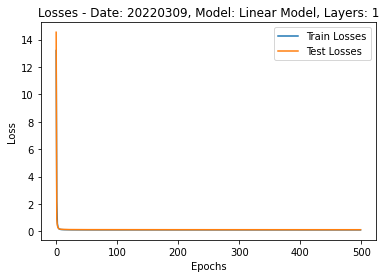

In [57]:
date = '20220309'
if date == '20220309':
    train_loader, test_loader, toy_loader = get_loaders(osim_dataset_20220309)
    output_size = 96
else: 
    # train_loader, test_loader, toy_loader = get_loaders(osim_dataset_20220405)
    output_size = 89

model = LinearModel(input_size=24, output_size=output_size)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=8, min_lr=0.00005)
total_params = sum(p.numel() for p in model.parameters())

print('{}, full dataset'.format(model.name))
# print('Model Number: {}'.format(i))
# print('Num Layers: {}, Hidden Layer Dimensionality: {}, Total Parameters: {}'\
#     .format(model.num_layers, model.hidden_layer_dim, total_params))

train_losses = []
val_losses = []
test_losses = []
start = time.time()
for epoch in range(500):
    lr = scheduler.optimizer.param_groups[0]['lr']
    train_loss = train(train_loader, model, optimizer, criterion)
    test_loss = test(train_loader, model, optimizer, criterion, scheduler)
    # scheduler.step(test_loss)
    if epoch % 50==0:
        print('Epoch: {:03d}, LR: {:7f}, Train Loss: {:.7f}, Test Loss: {:.7f}'\
              .format(epoch, lr, train_loss, test_loss))
    train_losses.append(train_loss)
    test_losses.append(test_loss)

end = time.time()
print('Time to train model: {}'.format(end-start))
plt.plot(train_losses)
plt.plot(test_losses)
plt.title('Losses - Date: {}, Model: {}, Layers: {}'.format(date, model.name, model.num_layers))
# plt.title('Losses - Date 20220405, Linear Model, learning rate 0.01, full dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train Losses', 'Test Losses'])
plt.show()

In [58]:
train_predictions, train_targets = predict(train_loader, model)
test_predictions, test_targets = predict(test_loader, model)

In [59]:
train_predictions.shape

(14375, 96)

In [60]:
train_r2 = r2_score(train_targets,train_predictions)
test_r2 = r2_score(test_targets,test_predictions)
print('Train r^2: {}, Test r^2: {}'.format(train_r2, test_r2))

Train r^2: -0.02673223759025518, Test r^2: -0.3324679110824997


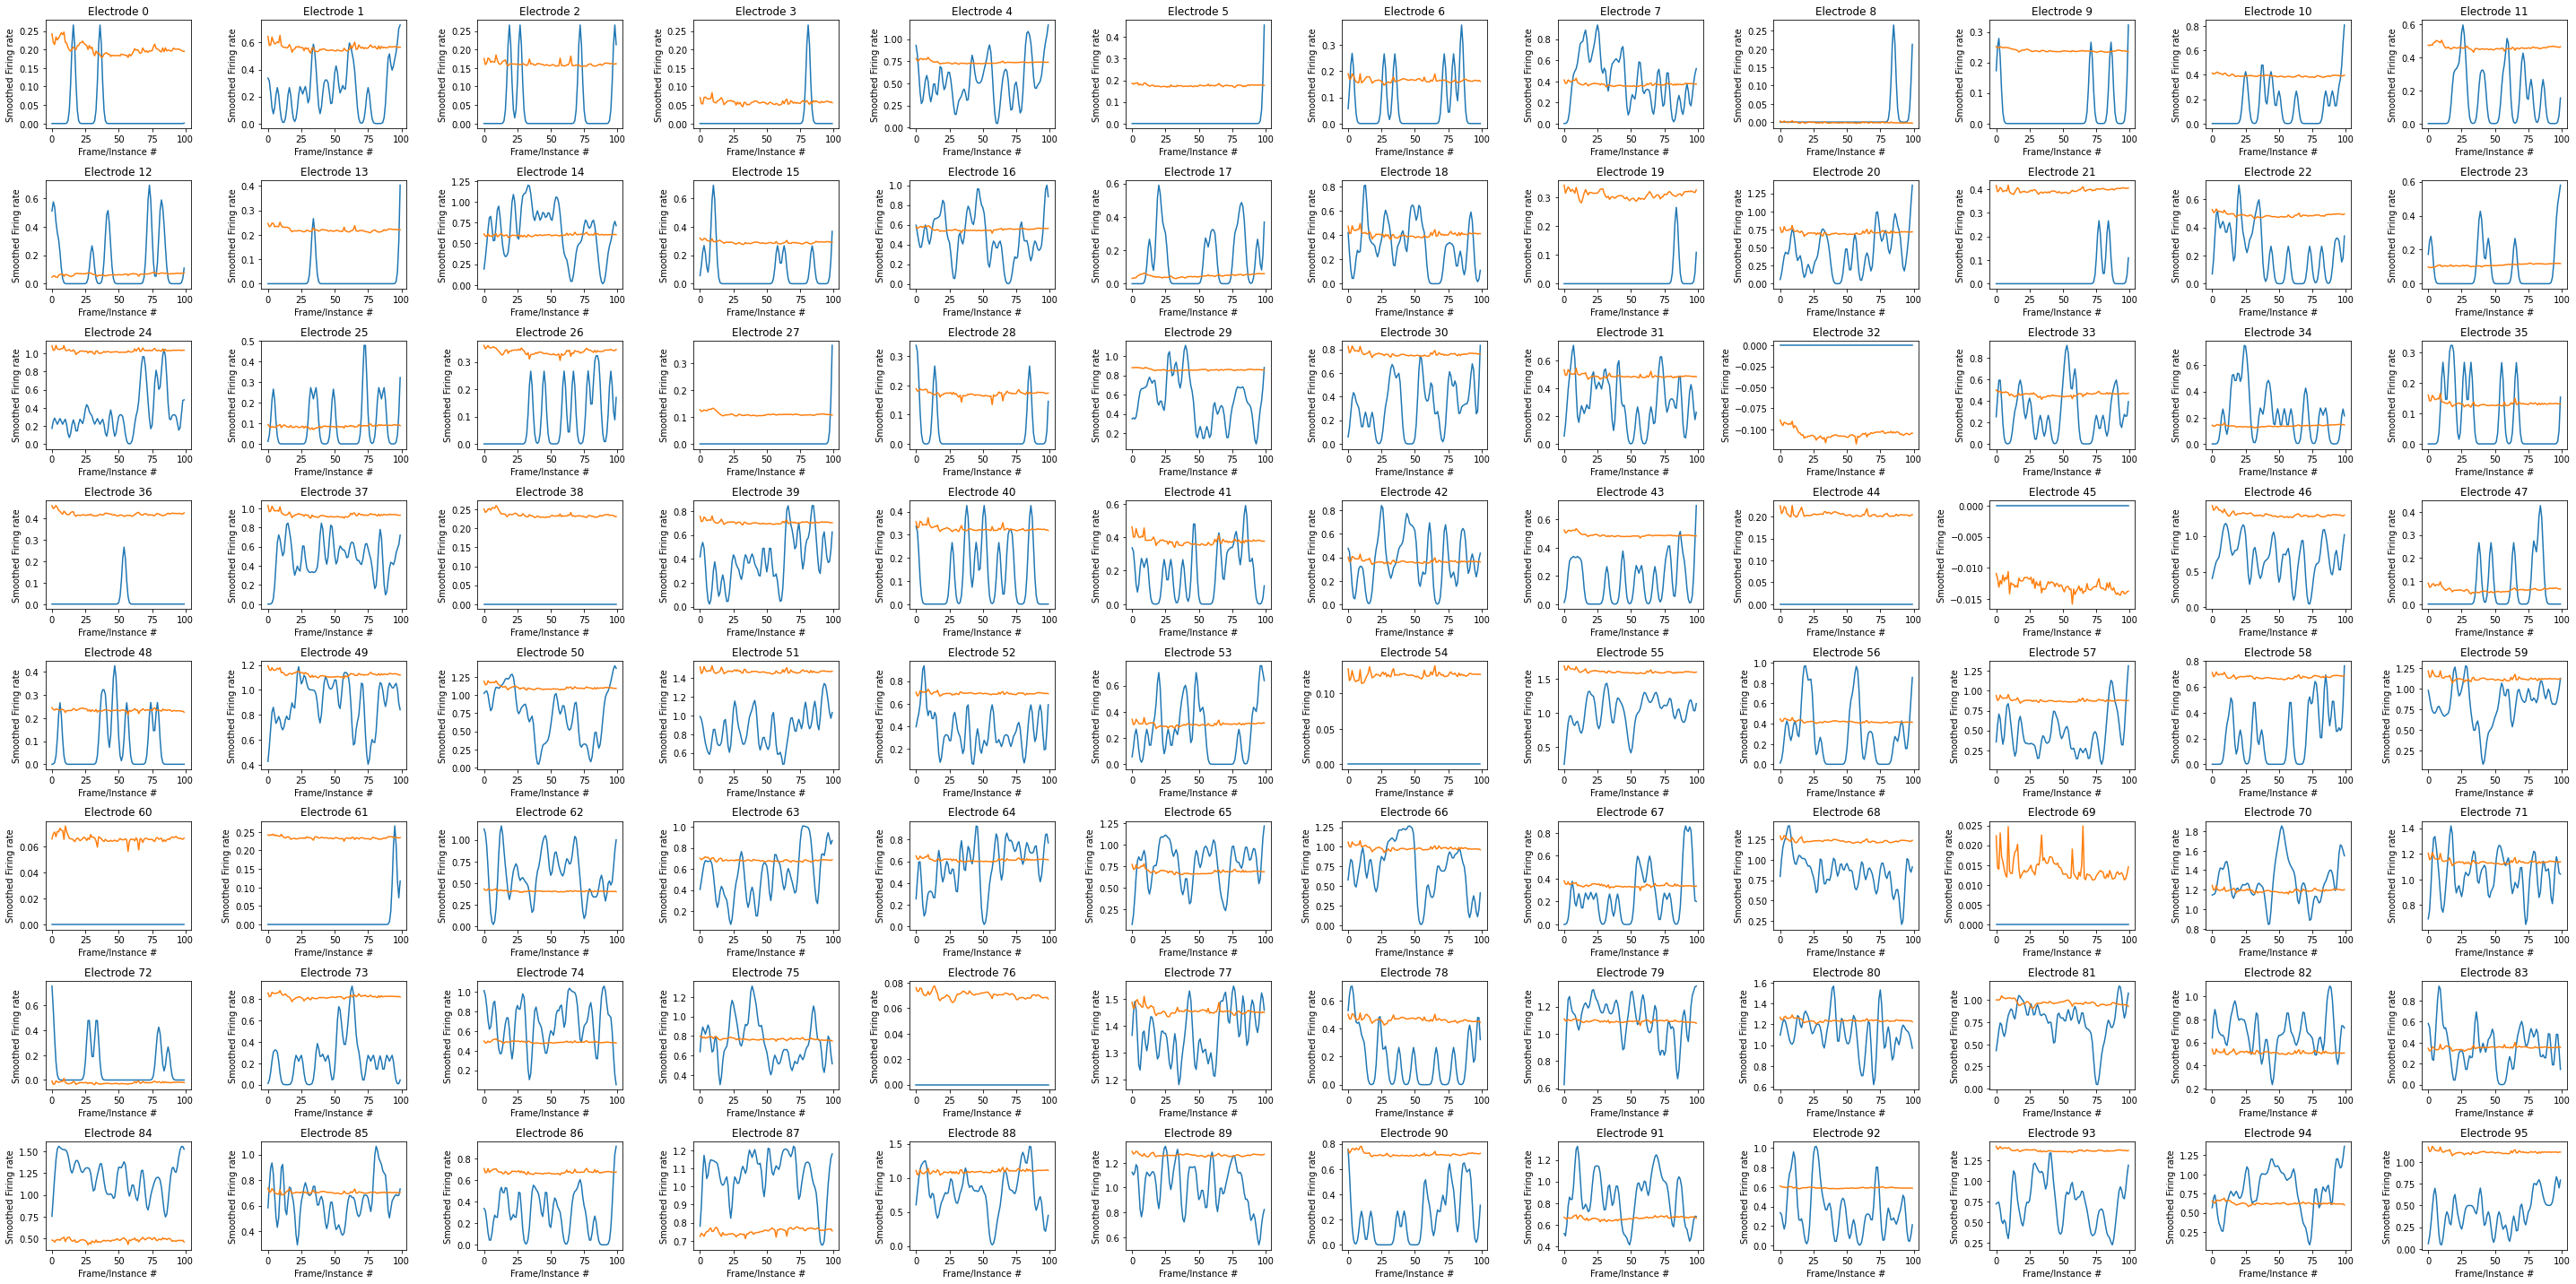

In [ ]:
nrows,ncols=8, 12
f, ax = plt.subplots(nrows, ncols)
f.subplots_adjust(top=1.2)
f.set_size_inches(40, 20)
for k in range(nrows*ncols):
    i = k-(int(k/ncols)*ncols)
    j = int(k/ncols)
    ax[j][i].plot(train_targets[:100,k])
    ax[j][i].plot(train_predictions[:100,k])
    ax[j][i].set_xlabel('Frame/Instance #')
    ax[j][i].set_ylabel('Smoothed Firing rate')
    ax[j][i].set_title('Electrode {}'.format(k))
    # if k==nrows*ncols-1:
    #     ax[j][i].plot(train_instance_data[2][500:600,k])
    #     ax[j][i].plot(train_instance_data[3][:100,k])
    #     ax[j][i].set_xlabel('Frame/Instance #')
    #     ax[j][i].set_ylabel('Smoothed Firing rate')
    #     ax[j][i].set_title('Electrode {}'.format(k))
        # ax[j][i].plot(np.arange(100))
    # else:
    #     ax[j][i].plot(train_instance_data[2][:100,k])
    #     ax[j][i].plot(train_instance_data[3][:100,k])
    #     ax[j][i].set_xlabel('Frame/Instance #')
    #     ax[j][i].set_ylabel('Smoothed Firing rate')
    #     ax[j][i].set_title('Electrode {}'.format(k))
# f.suptitle('All electrodes, first 100 instances (frames)')
plt.tight_layout()
plt.show()